In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/df.csv', index_col='Date', parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

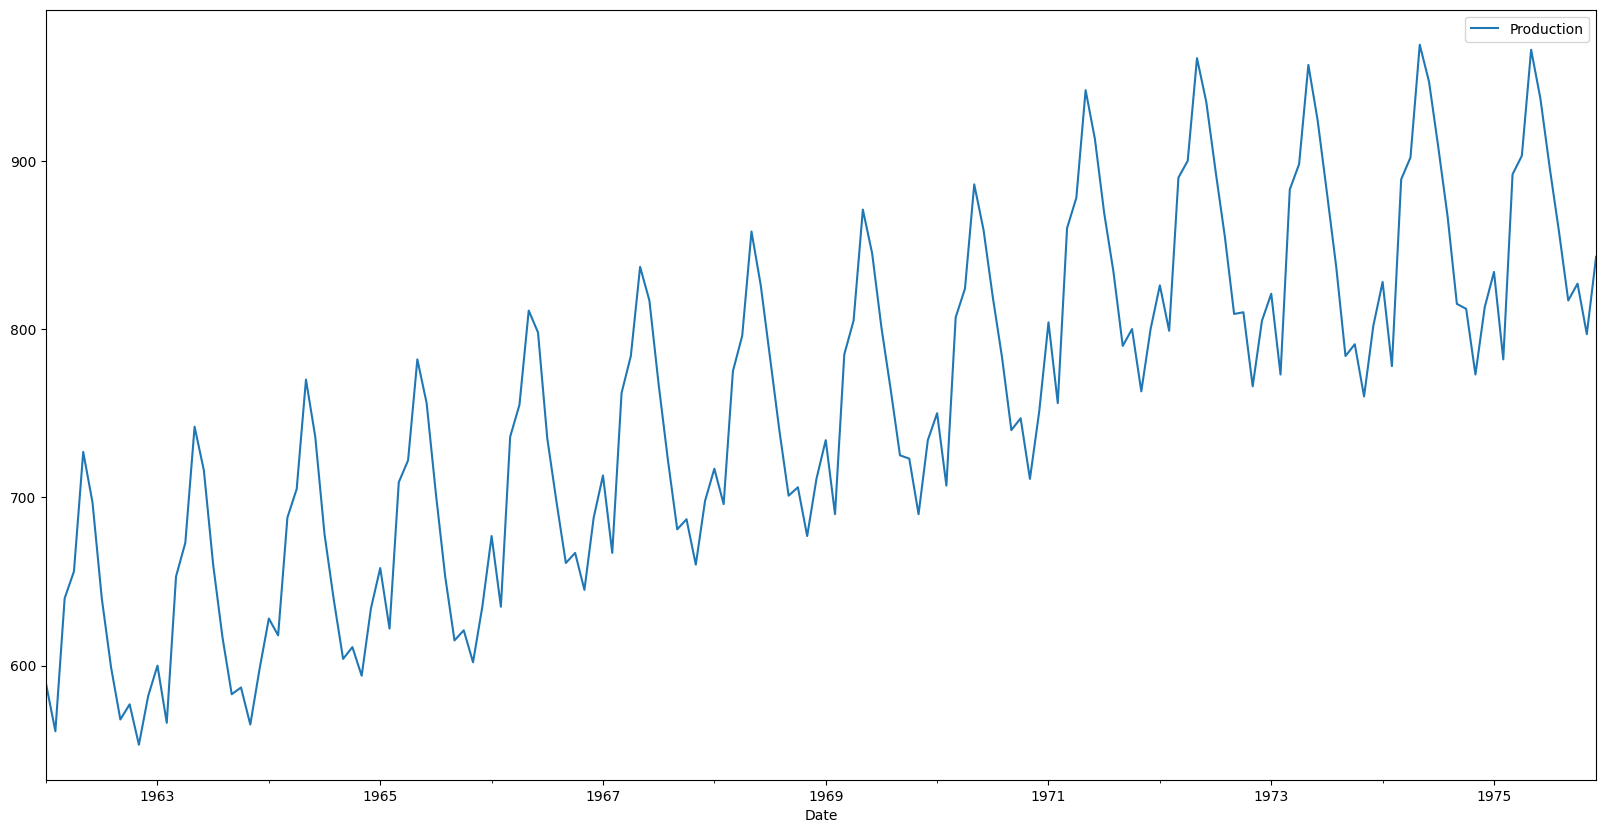

In [4]:
df.plot(figsize=(20,10))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

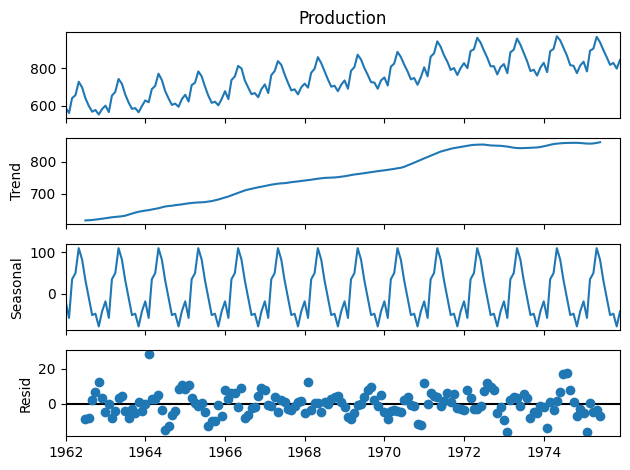

In [6]:
results = seasonal_decompose(df['Production'])
results.plot();

In [7]:
len(df)

168

In [8]:
train = df.iloc[:156]
test = df.iloc[156:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
df.head(), df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [11]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [13]:
from keras.preprocessing.sequence import TimeseriesGenerator


In [14]:
# define generator model
n_inputs = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_inputs, batch_size=1)

In [15]:
X,y = generator[1]
print(f'Given the array: \n {X.flatten()}')
print(f'Predict this y: \n {y}')

Given the array: 
 [0.01923077 0.20913462 0.24759615]
Predict this y: 
 [[0.41826923]]


In [16]:
X.shape

(1, 3, 1)

In [17]:
# now we're going to do the same thing but with 12 months of data
n_inputs = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_inputs, batch_size=1)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [19]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_inputs, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# fit model
model.fit(generator, epochs=50)

Epoch 1/50
144/144 [==============================] - 3s 7ms/step - loss: 0.0510
Epoch 2/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0244
Epoch 3/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0186
Epoch 4/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0171
Epoch 5/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0098
Epoch 6/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0073
Epoch 7/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0053
Epoch 8/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0055
Epoch 9/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0056
Epoch 10/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0049
Epoch 11/50
144/144 [==============================] - 2s 10ms/step - loss: 0.0051
Epoch 12/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0048
Epoch 13/50
144/144 [==

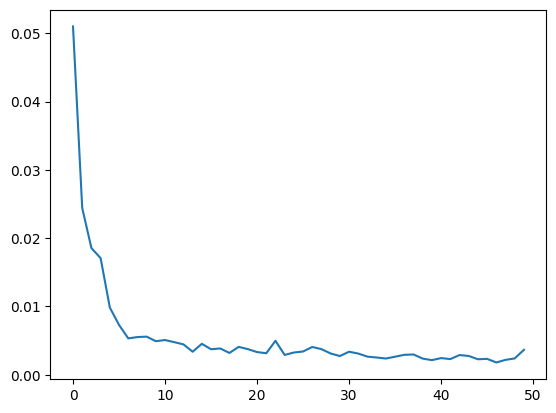

In [22]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [25]:
last_train_batch = scaled_train[-12:]

In [26]:
last_train_batch = last_train_batch.reshape(1, n_inputs, n_features)

In [27]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 246ms/step


array([[0.64648485]], dtype=float32)

In [29]:
scaled_test[0]

array([0.67548077])

In [31]:
test_prediction = []

first_eval_batch = scaled_train[-n_inputs:]
current_batch = first_eval_batch.reshape((1, n_inputs, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_prediction.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 29ms/step


In [32]:
test_prediction

[array([0.64648485], dtype=float32),
 array([0.6237312], dtype=float32),
 array([0.7934923], dtype=float32),
 array([0.86543], dtype=float32),
 array([0.98177093], dtype=float32),
 array([0.97037476], dtype=float32),
 array([0.89960706], dtype=float32),
 array([0.80096567], dtype=float32),
 array([0.6862245], dtype=float32),
 array([0.64074874], dtype=float32),
 array([0.5806402], dtype=float32),
 array([0.6167904], dtype=float32)]

In [33]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [36]:
true_predictions = scaler.inverse_transform(test_prediction)
true_predictions

array([[821.93769836],
       [812.47217751],
       [883.09280396],
       [913.01887894],
       [961.41670799],
       [956.67590141],
       [927.23653793],
       [886.20171738],
       [838.46940041],
       [819.55147552],
       [794.54632187],
       [809.58481216]])

In [37]:
test['Predictions'] = true_predictions

C:\Users\Sabbir\AppData\Local\Temp\ipykernel_10548\512873847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_preditcions


<Axes: xlabel='Date'>

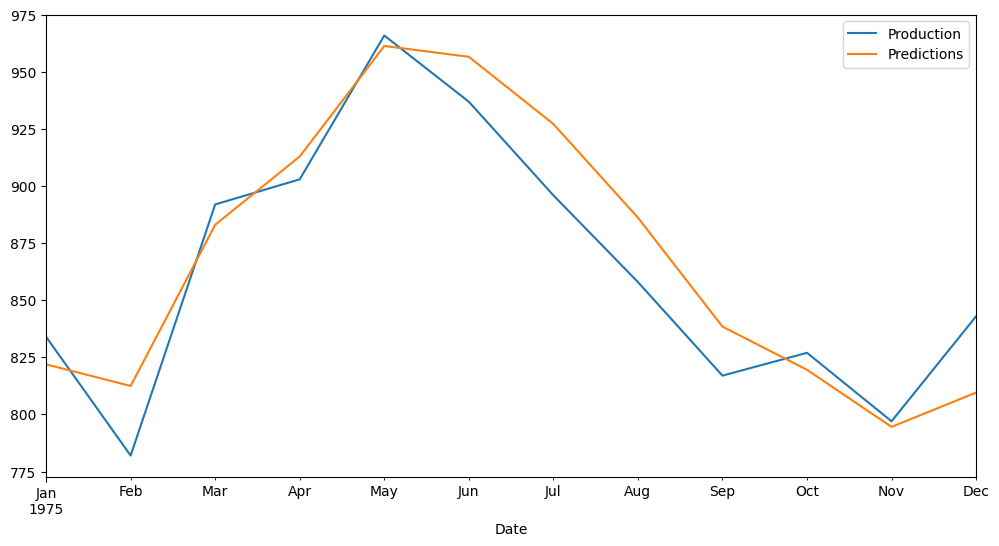

In [38]:
test.plot(figsize=(12,6))

In [39]:
# calculate the error of the model
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test['Production'], test['Predictions']))
print(rms)

20.55882943209515
